**Tabla de contenido**

- [Introducción](#Introducción)
- [Lib](#Lib)
- [Lectura de datos](#Lectura-de-datos)
- [Feature engineering](#Feature-engineering)
- [Muestra](#Muestra)
- [Entrenamiento y prueba](#Entrenamiento-y-prueba)
- [Predicciones](#Predicciones)
- [Guardar modelos](#Guardar-modelos)

# Introducción

En este cuaderno guardaremos los modelos y se generará una muestra para realizar predicciones en un rango específico de fechas. Los modelos se guardarán con la extensión **"*.pkl"** y la muestra se exportará en un archivo CSV.

# Lib

Para garantizar el correcto funcionamiento de este cuaderno, se requieren las siguientes librerías:

- **Python:** Versión 3.12.3
- **Pandas:** Versión 2.2.3
- **Matplotlib:** Versión 3.10.0
- **NumPy:** Versión 1.26.0
- **Seaborn:** Versión 0.13.2
- **Scikit-learn:** Versión 1.5.2
- **Shap:** Versión 0.46.0
- **Scipy:** Versión 1.14.1
- **XGBoost:** Versión 2.1.3
- **statsmodels:** Versión 0.14.4

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import pickle

# Lectura de datos

Los datos fueron leídos desde el archivo **WalmartSalesClean.csv**, que fue exportado desde el cuaderno LDV-APV y utiliza el carácter **","** como delimitador.

**Para leer correctamente este archivo, es necesario proporcionar la ruta donde se encuentra almacenado.**

In [2]:
os.chdir('D:\\6. NEXER\\master\\Solucion TFM\\2. Datos en CSV')
WalmartSales = pd.read_csv('WalmartSalesClean.csv', delimiter=',')
WalmartSales.head()

,Date,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Events
0,2010-02-12,1,164195744,1,38.51,2.548,211.242176,8.106,1
1,2010-02-19,1,161196816,0,39.93,2.514,211.289139,8.106,0
2,2010-02-26,1,140972752,0,46.63,2.561,211.319642,8.106,0
3,2010-03-05,1,155480672,0,46.50,2.625,211.350144,8.106,0
4,2010-03-12,1,143954160,0,57.79,2.667,211.380646,8.106,0


# Feature engineering

Dado que en el análisis de las características más influyentes en las decisiones del modelo XGBRegressor se identificaron Store, CPI, Unemployment, Holiday_Events y week como las más relevantes, nos centraremos únicamente en estas variables.

In [3]:
WalmartSales['Date'] = pd.to_datetime(WalmartSales['Date'],format = '%Y-%m-%d')
WalmartSales['week'] = WalmartSales['Date'].dt.isocalendar().week
WalmartSales = WalmartSales[['Weekly_Sales','Store', 'CPI', 'Unemployment', 'Holiday_Events', 'week','Date']]
WalmartSales =WalmartSales.set_index('Date',drop=True)
WalmartSales.head()

,Weekly_Sales,Store,CPI,Unemployment,Holiday_Events,week
Date,,,,,,
2010-02-12,164195744,1,211.242176,8.106,1,6
2010-02-19,161196816,1,211.289139,8.106,0,7
2010-02-26,140972752,1,211.319642,8.106,0,8
2010-03-05,155480672,1,211.350144,8.106,0,9
2010-03-12,143954160,1,211.380646,8.106,0,10


# Muestra

Extraeremos una muestra que corresponderá a las últimas dos fechas de cada tienda, lo que dará un total de 90 datos. El objetivo es realizar predicciones utilizando datos que no hayan sido vistos por los modelos, una vez que estos hayan sido entrenados y validados.

In [4]:
Ventas = pd.concat(
    [WalmartSales[WalmartSales['Store'] == i].iloc[-2:] for i in range(1, 46)]
)
WalmartSalesC = WalmartSales.copy()
WalmartSales = WalmartSales.drop(Ventas.index)
Ventas.head()
Ventas.to_csv('Datos de ventas para predicciones.csv',index=True)

# Escalador de datos

In [5]:
def normalizar_datos (target,df):
    X = df.drop(columns=[target],axis=1)
    y = df[target]
    escalador = preprocessing.RobustScaler()
    X_nor = pd.DataFrame(escalador.fit_transform(X),
                         columns = X.columns,
                         index=X.index)
    dfnor = pd.concat([y,X_nor],axis=1)
    return dfnor,escalador

In [6]:
df1 = WalmartSales.copy()
df1nor,escalador = normalizar_datos (target='Weekly_Sales',
                          df = df1)

# Entrenamiento y prueba

Extraeremos una muestra que se utilizará para validar los modelos. Además, definiremos las variables independientes, la variable objetivo y los diccionarios con los parámetros que emplearán los modelos.

In [7]:
datanor, muestra = train_test_split(df1nor, test_size=0.1, random_state=42)
independientes = datanor.drop(columns=['Weekly_Sales'],axis=1) 
objetivo = datanor['Weekly_Sales']
# diccionarios
xgb_params = {'n_estimators': 81, 
          'learning_rate': 0.1, 
          'max_depth': 7, 
          'min_child_weight': 10, 
          'subsample': 0.7, 
          'colsample_bytree': 0.6, 
          'gamma': 0.8}
RFR_params= {'n_estimators': 66,
             'max_depth': 12,
             'max_features': 0.8,
             'min_samples_split': 4,
             'min_samples_leaf': 1,
             'bootstrap': False}
GBR_params = {'n_estimators': 93,
              'learning_rate': 0.1,
              'max_depth': 12,
              'min_samples_split': 4,
              'min_samples_leaf': 5,
              'subsample': 0.692131006950942,
              'criterion': 'squared_error',
              'warm_start': False,
              'tol': 0.004043284891718401}
muestra.to_csv('Datos de ventas para predicciones test.csv',index=True)

Definamos la función que evalúa los modelos y obtengamos los resultados.

In [8]:
def evaluar_modelo(estimador, independientes, objetivo):
    resultados_estimador = cross_validate(estimador, independientes, objetivo,
                     scoring="r2", n_jobs=-1, cv=60)
    return resultados_estimador

In [9]:
resultados = {}
resultados["xgb"] = evaluar_modelo(XGBRegressor(**xgb_params),
                                   independientes,
                                   objetivo)

In [10]:
resultados["Foresre"] = evaluar_modelo(RandomForestRegressor(**RFR_params),
                                   independientes,
                                   objetivo)

In [11]:
resultados["gradientBR"] = evaluar_modelo(GradientBoostingRegressor(**GBR_params),
                                   independientes,
                                   objetivo)

**Veamos los resultados**

In [12]:
def ver_resultados(resultados):
    resultados_df = pd.DataFrame(resultados).T

    for col in resultados_df:
        resultados_df[col] = resultados_df[col].apply(np.mean)

        resultados_df[col + "_idx"] = resultados_df[col] / resultados_df[col].max()
    return resultados_df

resultados_df= ver_resultados(resultados)
# organizando resultados.
resultados_df = resultados_df.sort_values(by=['test_score', 'fit_time'], ascending=[False, True])
resultados_df.head()

,fit_time,score_time,test_score,fit_time_idx,score_time_idx,test_score_idx
gradientBR,2.146337,0.006338,0.979034,1.000000,0.495236,1.000000
xgb,0.504644,0.008776,0.968975,0.235119,0.685766,0.989726
Foresre,1.609435,0.012798,0.961805,0.749852,1.000000,0.982402


**Esto es excelente.** Los modelos explican más del 90% de la variabilidad de las ventas semanales. Ahora, volvamos a entrenar los modelos, realicemos la prueba y guardemos los modelos y sus predicciones.


In [13]:
xgb = XGBRegressor(**xgb_params)
Foresre = RandomForestRegressor(**RFR_params)
gradientBR = GradientBoostingRegressor(**GBR_params)
# entrenamiento
xgb.fit(independientes, objetivo)
Foresre.fit(independientes, objetivo)
gradientBR.fit(independientes, objetivo)

GradientBoostingRegressor(criterion='squared_error', max_depth=12,
                          min_samples_leaf=5, min_samples_split=4,
                          n_estimators=93, subsample=0.692131006950942,
                          tol=0.004043284891718401)

# Predicciones

Veamos las predicciones de los modelos en el set de validación.

In [14]:
X = muestra.drop(columns=['Weekly_Sales'],axis=1)
muestra['xgb_Pred'] = xgb.predict(X)
muestra['Foresre_Pred'] = Foresre.predict(X)
muestra['gradientBR_Pred'] = gradientBR.predict(X)

Veamos cómo salieron esas predicciones.

In [15]:
X_muestra_original = escalador.inverse_transform(X)
muestra_original = pd.DataFrame(X_muestra_original,
                                columns=X.columns,
                                index=X.index)

# Añadimos la columna 'Weekly_Sales' de vuelta al dataframe original
muestra_original[['Weekly_Sales','xgb_Pred','Foresre_Pred','gradientBR_Pred']] = muestra[['Weekly_Sales',
                                                                                          'xgb_Pred',
                                                                                          'Foresre_Pred',
                                                                                          'gradientBR_Pred']]
muestra_original[['Store','Holiday_Events','week']] =muestra_original[['Store','Holiday_Events','week']].astype(int)
muestra_original.head()

,Store,CPI,Unemployment,Holiday_Events,week,Weekly_Sales,xgb_Pred,Foresre_Pred,gradientBR_Pred
Date,,,,,,,,,
2010-06-11,43,203.372762,9.593,0,23,68402392,65335656.0,6.799630e+07,6.864338e+07
2011-08-12,23,136.144128,4.584,0,32,138095200,141771408.0,1.408221e+08,1.411607e+08
2010-02-12,22,135.411302,8.283,1,6,102257128,107817064.0,1.030211e+08,1.095226e+08
2011-10-21,9,221.149824,6.054,0,42,55707520,54294096.0,5.777851e+07,5.674265e+07
2012-04-06,1,221.435622,7.143,0,14,189967680,159638288.0,1.600272e+08,1.679092e+08


Restauraremos el dataframe de entrenamiento a su forma original y compararemos los datos reales con los predichos.

In [16]:
independientesO = pd.DataFrame(escalador.inverse_transform(independientes),
                                columns=independientes.columns,
                                index=independientes.index)
df2 = pd.concat([objetivo,independientesO],axis=1)
df2[['Store','Holiday_Events','week']] =df2[['Store','Holiday_Events','week']].astype(int)
df2.head()

,Weekly_Sales,Store,CPI,Unemployment,Holiday_Events,week
Date,,,,,,
2010-03-12,38420068,3,214.702758,7.368,0,10
2010-04-09,119801496,35,135.785638,9.051,0,14
2011-01-07,91011024,12,127.191770,14.021,0,1
2010-08-20,143019232,11,214.931430,7.346,0,33
2010-07-16,58658368,16,189.612544,6.868,0,28


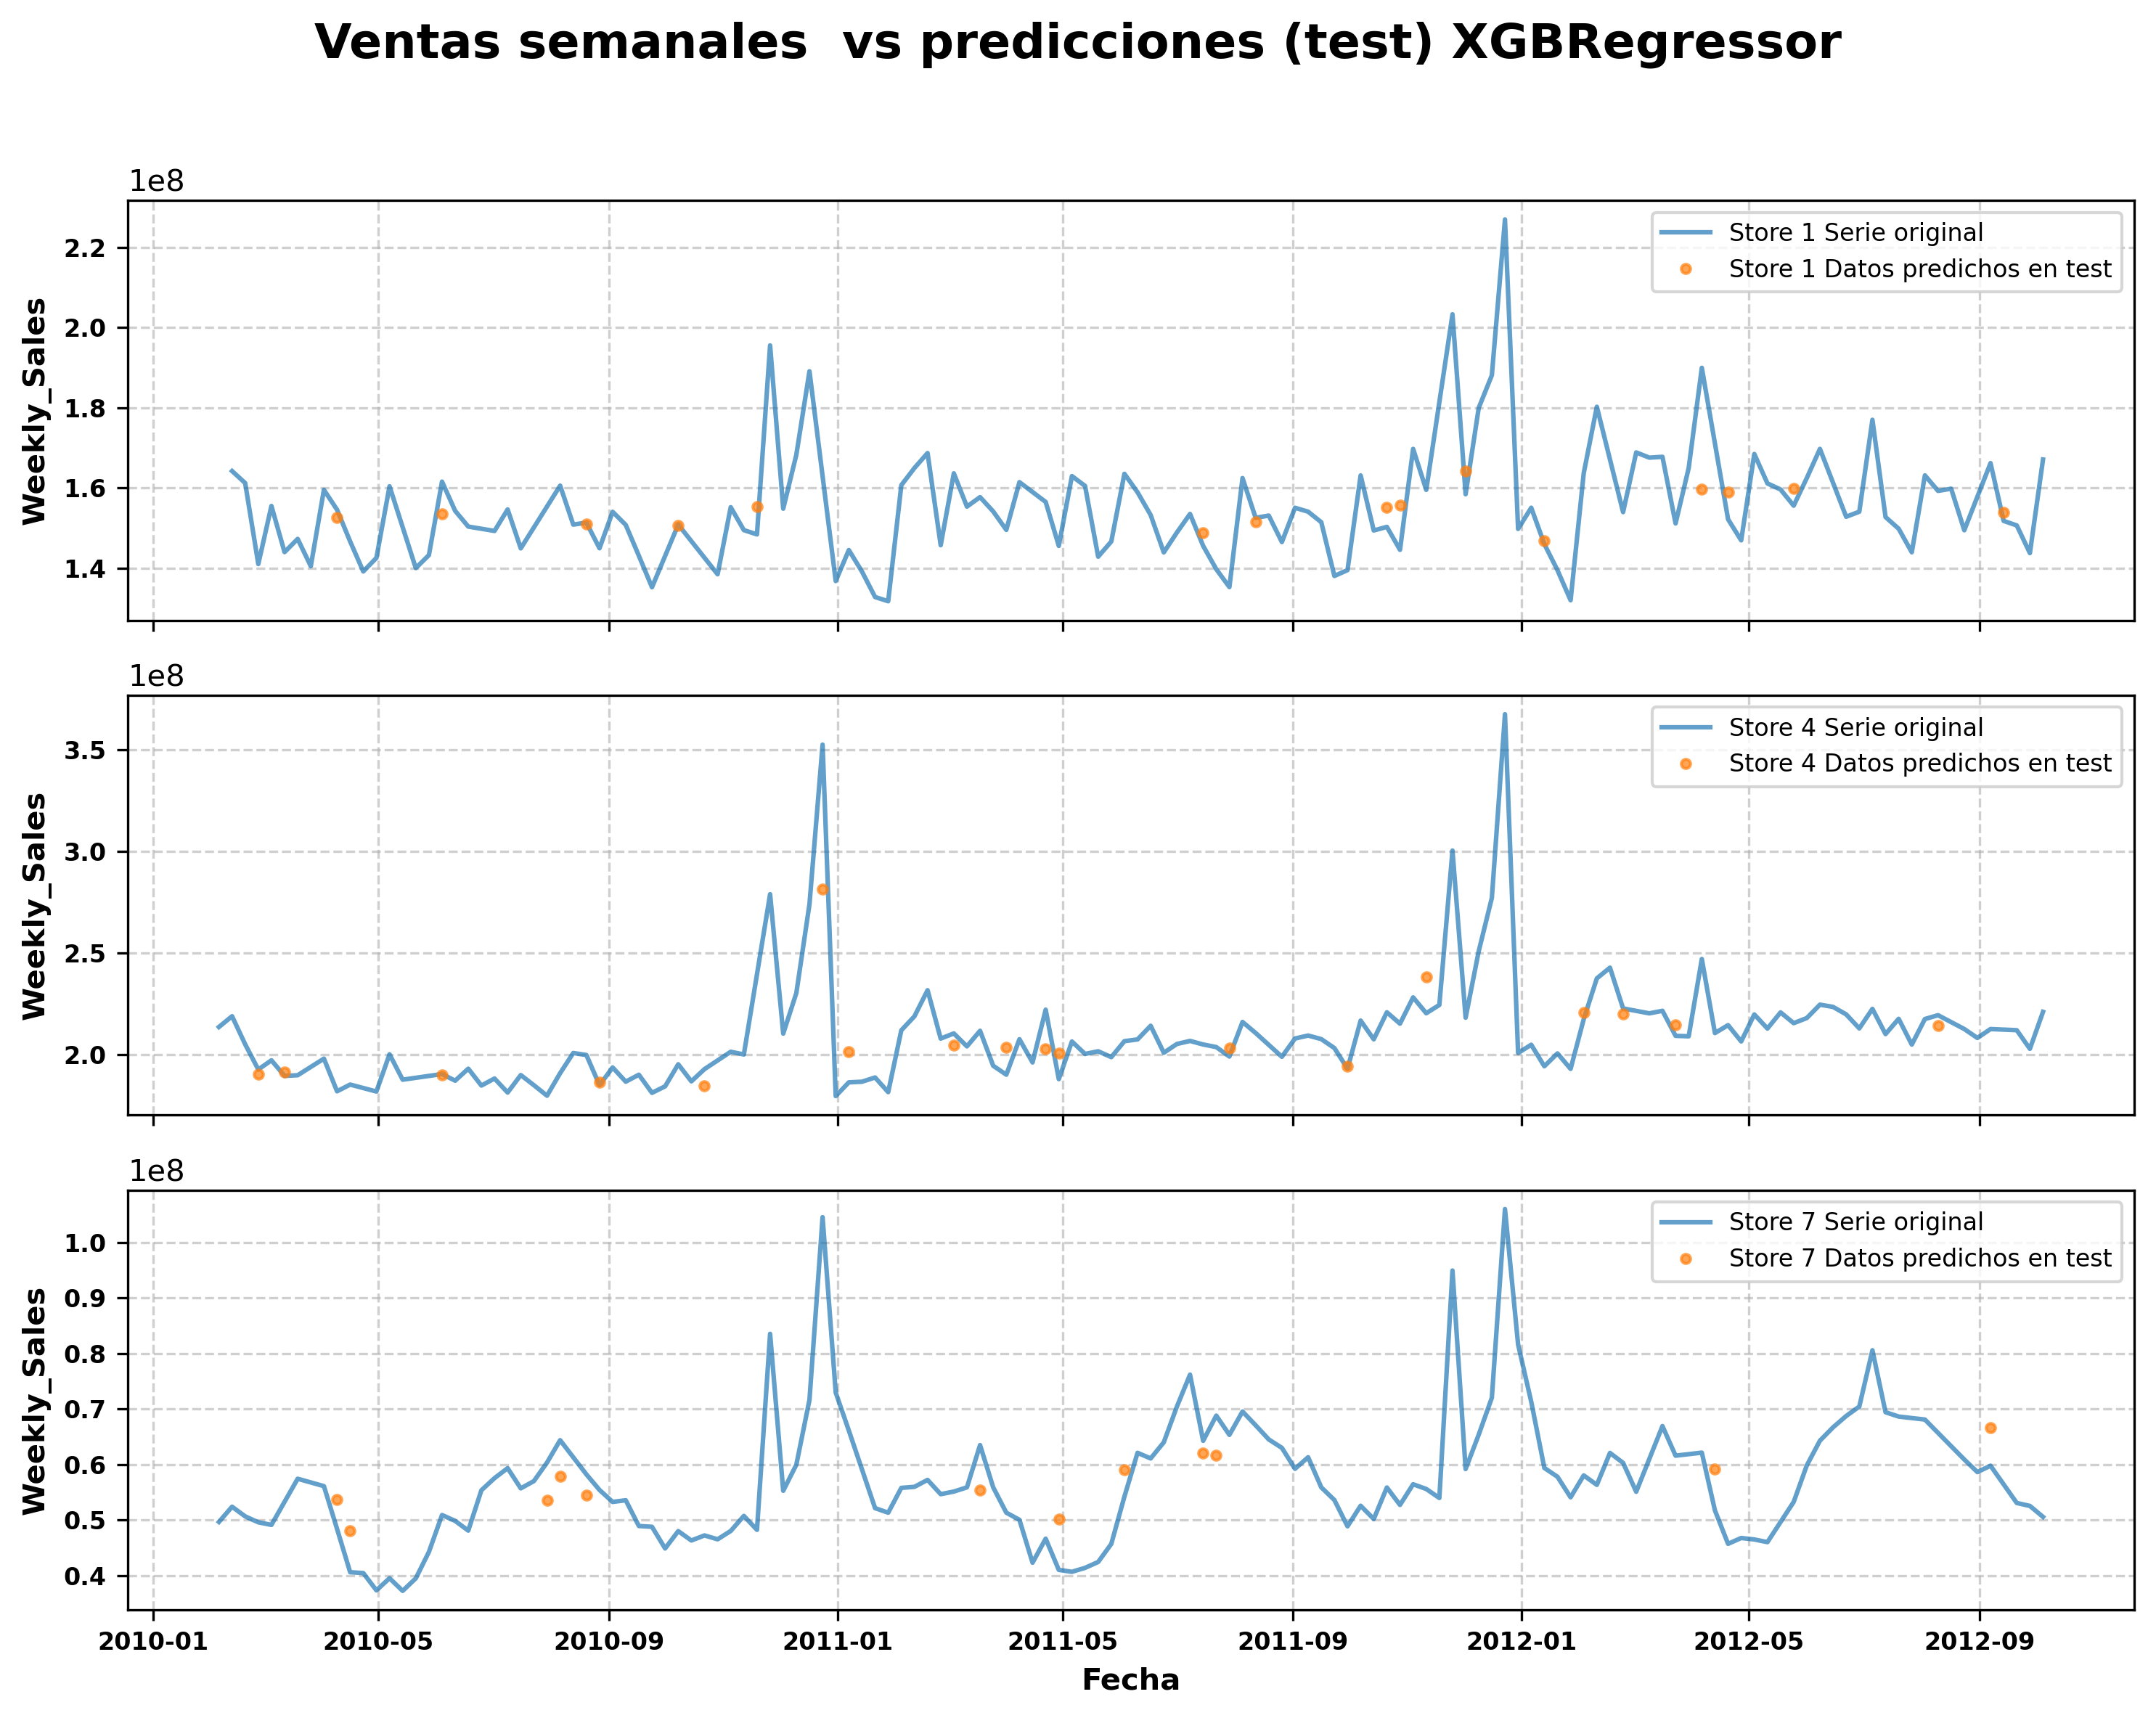

In [17]:
fig, axs = plt.subplots(3, figsize=(10, 8), sharex=True,dpi=300)
fig.suptitle('Ventas semanales  vs predicciones (test) XGBRegressor', fontsize=16, fontweight='bold')
stores = [1,4, 7]
for i, store in enumerate(stores):
    data = df1 [df1 ['Store'] == store]
    data2 = muestra_original [muestra_original['Store']==store] # predicciones
    axs[i].plot(data['Weekly_Sales'], '-', label=f'Store {store} Serie original', alpha=0.7)
    axs[i].plot(data2['xgb_Pred'], '.', label=f'Store {store} Datos predichos en test', alpha=0.7)
    # Configurar el eje Y
    axs[i].set_ylabel('Weekly_Sales', fontsize=10, fontweight='bold')
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].grid(visible=True, linestyle='--', alpha=0.6)
    axs[i].tick_params(axis='y', labelsize=8)
    for tick in axs[i].get_yticklabels():
        tick.set_fontweight('bold')

# Configurar el eje X solo para el último subplot
axs[-1].set_xlabel('Fecha', fontsize=10, fontweight='bold')
axs[-1].tick_params(axis='x', labelsize=8)
for tick in axs[-1].get_xticklabels():
    tick.set_fontweight('bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

Ahora veamos las predicciones para las últimas dos fechas.

In [19]:
X = Ventas.drop(columns=['Weekly_Sales'],axis=1)
X = pd.DataFrame(escalador.transform(X),
                         columns = X.columns,
                         index=X.index)
X.head()

,Store,CPI,Unemployment,Holiday_Events,week
Date,,,,,
2012-10-19,-1.000000,0.504710,-0.770979,0.0,0.739130
2012-10-26,-1.000000,0.504939,-0.770979,0.0,0.782609
2012-10-19,-0.954545,0.500187,-1.005828,0.0,0.739130
2012-10-26,-0.954545,0.500416,-1.005828,0.0,0.782609
2012-10-12,-0.909091,0.547955,-1.085082,0.0,0.695652


In [20]:
Ventas['xgb_Pred'] = xgb.predict(X)
Ventas['Foresre_Pred'] = Foresre.predict(X)
Ventas['gradientBR_Pred'] = gradientBR.predict(X)
Ventas.head()

,Weekly_Sales,Store,CPI,Unemployment,Holiday_Events,week,xgb_Pred,Foresre_Pred,gradientBR_Pred
Date,,,,,,,,,
2012-10-19,150806880,1,223.425715,6.573,0,42,153990208.0,1.679639e+08,1.584449e+08
2012-10-26,149365968,1,223.444250,6.573,0,43,154557504.0,1.679639e+08,1.582442e+08
2012-10-19,184799040,2,223.059814,6.170,0,42,181338320.0,1.664849e+08,1.830757e+08
2012-10-26,183445840,2,223.078349,6.170,0,43,185837952.0,1.664849e+08,1.828836e+08
2012-10-12,41080440,3,226.923981,6.034,0,41,42898660.0,3.788973e+07,4.023992e+07


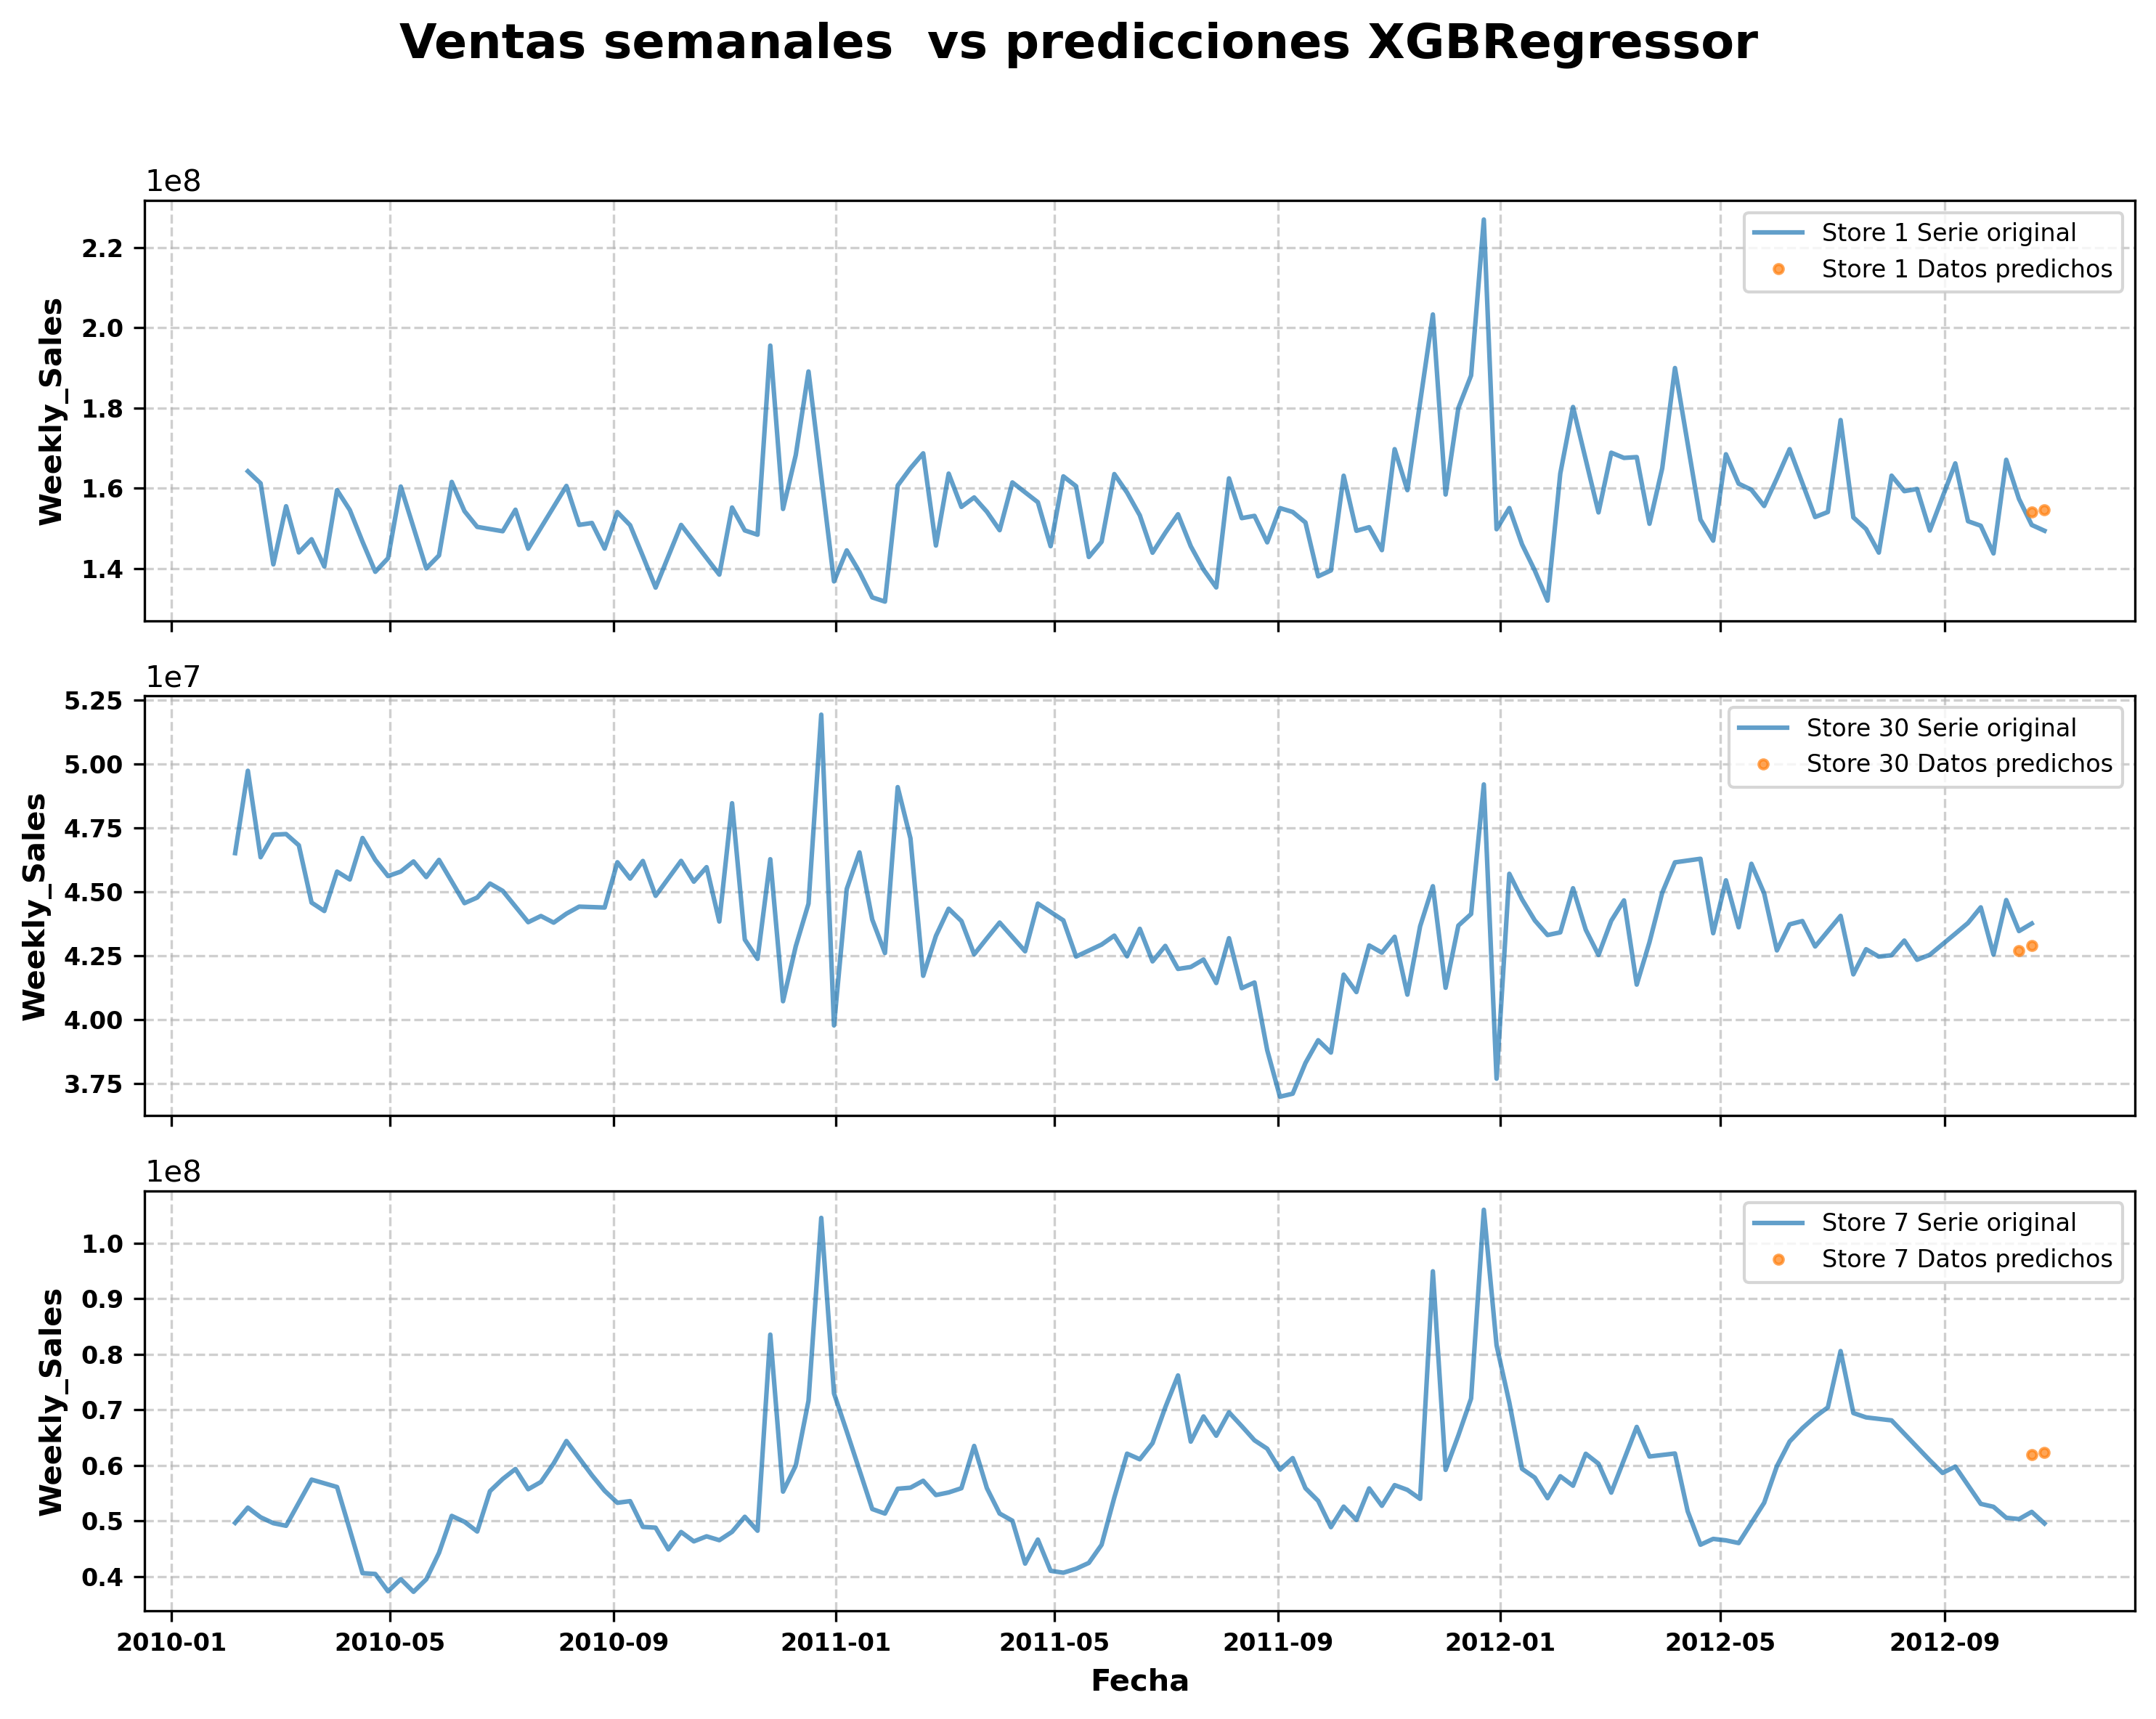

In [24]:
fig, axs = plt.subplots(3, figsize=(10, 8), sharex=True,dpi=300)
fig.suptitle('Ventas semanales  vs predicciones XGBRegressor', fontsize=16, fontweight='bold')
stores = [1,30, 7]
for i, store in enumerate(stores):
    data = WalmartSalesC[WalmartSalesC['Store'] == store]
    data2 = Ventas[Ventas['Store']==store] # predicciones
    axs[i].plot(data['Weekly_Sales'], '-', label=f'Store {store} Serie original', alpha=0.7)
    axs[i].plot(data2['xgb_Pred'], '.', label=f'Store {store} Datos predichos', alpha=0.7)
    # Configurar el eje Y
    axs[i].set_ylabel('Weekly_Sales', fontsize=10, fontweight='bold')
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].grid(visible=True, linestyle='--', alpha=0.6)
    axs[i].tick_params(axis='y', labelsize=8)
    for tick in axs[i].get_yticklabels():
        tick.set_fontweight('bold')

# Configurar el eje X solo para el último subplot
axs[-1].set_xlabel('Fecha', fontsize=10, fontweight='bold')
axs[-1].tick_params(axis='x', labelsize=8)
for tick in axs[-1].get_xticklabels():
    tick.set_fontweight('bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

# Guardar modelos

Guardemos los modelos en formato **'*.pkl'**. Es fundamental tener en cuenta que estos archivos se almacenarán en el directorio configurado mediante **os.chdir()**.

In [28]:
# Guardar los modelos en un diccionario
modelos = {
    "XGBRegressor": xgb,
    "RandomForestRegressor":Foresre,
    "GradientBoostingRegressor": gradientBR,
    "escalador":escalador
}
# Guardar todos los modelos en un archivo
nombre_archivo = "modelos.pkl"
with open(nombre_archivo, 'wb') as archivo:
    pickle.dump(modelos, archivo)
print(f"Modelo guardado en {os.path.join(os.getcwd(), nombre_archivo)}")


Modelo guardado en D:\6. NEXER\master\Solucion TFM\2. Datos en CSV\modelos.pkl
